In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# some constants
NUM_CLASSES = 4 # 1 added to include background
input_shape = (300, 300, 3)

In [3]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [4]:
# gt = pickle.load(open('gt_pascal.pkl', 'rb'))
gt = pickle.load(open('ground-truth.pkl', 'rb'))
keys = sorted(gt.keys())
shuffle(keys)
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [5]:
num_val

4437

In [6]:
num_train

17746

In [148]:
from random import randint

class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 translate_range=200,
                 stretch_range=200,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.translate_range = translate_range
        self.stretch_range = stretch_range
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, image):
        img = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        img = np.array(img, dtype = np.float64)
        random_bright = .5 + np.random.uniform()
        img[:, :, 2] = img[:, :, 2] * random_bright
        img[:, :, 2][img[:, :, 2] > 255]  = 255
        img = np.array(img, dtype = np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        return img

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        r = np.random.random()
        print('random', r)
        if r < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def translate(self, img, annotations):
        # Translation augmentation - expect unnormalized annotations
        h, w, _ = img.shape
        tr_x = self.translate_range * np.random.uniform() - self.translate_range/2
        tr_y = self.translate_range * np.random.uniform() - self.translate_range/2

        Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

        annotations[:, 0] = annotations[:, 0] + tr_x # xmin
        annotations[:, 2] = annotations[:, 2] + tr_x # xmax
        annotations[:, 1] = annotations[:, 1] + tr_y # ymin
        annotations[:, 3] = annotations[:, 3] + tr_y # ymax

        img_translated = cv2.warpAffine(img, Trans_M, (w, h))

        return img_translated, annotations

    
    def stretch(self, img, annotations):
        # Stretching augmentation - expect unnormalized annotations
        tr_x1 = self.stretch_range * np.random.uniform()
        tr_y1 = self.stretch_range * np.random.uniform()
        p1 = (tr_x1, tr_y1)
        tr_x2 = self.stretch_range * np.random.uniform()
        tr_y2 = self.stretch_range * np.random.uniform()
        p2 = (img.shape[1] - tr_x2, tr_y1)

        p3 = (img.shape[1] - tr_x2, img.shape[0] - tr_y2)
        p4 = (tr_x1, img.shape[0] - tr_y2)

        pts1 = np.float32([[p1[0], p1[1]], 
                           [p2[0], p2[1]],
                           [p3[0], p3[1]], 
                           [p4[0], p4[1]]])
        pts2 = np.float32([[0, 0],
                           [img.shape[1], 0], 
                           [img.shape[1], img.shape[0]],
                           [0, img.shape[0]]])

        M = cv2.getPerspectiveTransform(pts1, pts2)
        img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
        img = np.array(img, dtype=np.uint8)

        annotations[:, 0] = (annotations[:, 0] - p1[0]) / (p2[0] - p1[0]) * img.shape[1] # xmin
        annotations[:, 2] = (annotations[:, 2] - p1[0]) / (p2[0] - p1[0]) * img.shape[1] # xmax
        annotations[:, 1] = (annotations[:, 1] - p1[1]) / (p3[1] - p1[1]) * img.shape[0] # ymin
        annotations[:, 3] = (annotations[:, 3] - p1[1]) / (p3[1] - p1[1]) * img.shape[0] # ymax

        return img, annotations
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def _denormalize(self, img, annotations):
        h, w, _ = img.shape
        annotations[:, 0] = annotations[:, 0] * w
        annotations[:, 2] = annotations[:, 2] * w
        annotations[:, 1] = annotations[:, 1] * h
        annotations[:, 3] = annotations[:, 3] * h
        return annotations

    def _normalize(self, img, annotations):
        h, w, _ = img.shape
        annotations[:, 0] = annotations[:, 0] / w
        annotations[:, 2] = annotations[:, 2] / w
        annotations[:, 1] = annotations[:, 1] / h
        annotations[:, 3] = annotations[:, 3] / h
        return annotations
    
    def generate(self, train=True):
        while True:
            if train:
                keys = self.train_keys
            else:
                keys = self.val_keys
            
            inputs = []
            targets = []
            for i, key in enumerate(keys):
                img_path = self.path_prefix + key
                img = imread(img_path)
                y = self.gt[key].copy()
                print(key)
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size)

                if train:
                    # add original image (without jittering) for training
                    inputs.append(img.copy())
                    targets.append(self.bbox_util.assign_boxes(y.copy()))
                    
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    img, y = self.translate(img, self._denormalize(img, y))
                    img, y = self.stretch(img, y)
                    y = self._normalize(img, y)
                    
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    img = img.astype('float32')
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                    
                if len(targets) == self.batch_size or i == len(keys) - 1:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [149]:
path_prefix = 'resources/udacity-dataset/'
gen = Generator(gt, bbox_util, 16, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False, saturation_var=0.,
                 brightness_var=0.5,
                 contrast_var=0.,
                 hflip_prob=0.5,
                 translate_range=10,
                 stretch_range=10,
                 lighting_std=0.)

In [150]:
X, y = next(gen.generate(train=True))

object-detection-crowdai/1479502803767526994.jpg
random 0.16273456928356156
object-dataset/1478898007532111794.jpg
random 0.3673900548968909
object-detection-crowdai/1479499896547407309.jpg
random 0.7590673936888337
object-detection-crowdai/1479505732445406063.jpg
random 0.6401078184422546
object-detection-crowdai/1479502249227876081.jpg
random 0.6355500896245931
object-detection-crowdai/1479503003278765245.jpg
random 0.7548348793878658
object-detection-crowdai/1479501700192412886.jpg
random 0.2236498222331842
object-dataset/1478899667699552911.jpg
random 0.3656866682846701


In [142]:
X.shape

(16, 300, 300, 3)

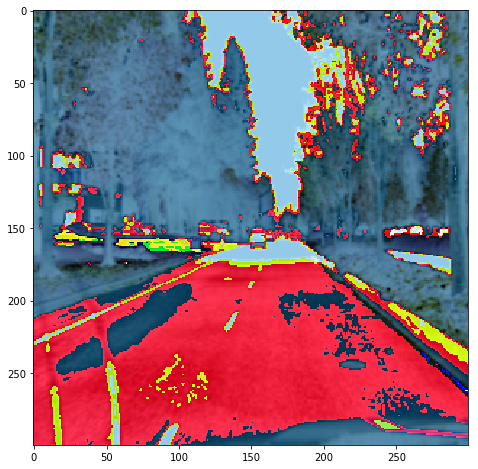

In [156]:
def draw_each(img, bboxes):
    for bbox in bboxes:
        xmin = int(round(bbox[0] * img.shape[1]))
        ymin = int(round(bbox[1] * img.shape[0]))
        xmax = int(round(bbox[2] * img.shape[1]))
        ymax = int(round(bbox[3] * img.shape[0]))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax),(0, 255, 0), 1)
    return img
plt.imshow(X[3])

In [12]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)

In [13]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [14]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [16]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim, metrics=['precision', 'recall', 'fbeta_score'],
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [11]:
nb_epoch = 30
# history = model.fit_generator(gen.generate(True), gen.train_batches,
#                               nb_epoch, verbose=1,
#                               callbacks=callbacks,
#                               validation_data=gen.generate(False),
#                               nb_val_samples=gen.val_batches,
#                               nb_worker=1)
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=0,
                              callbacks=callbacks)

/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
4640/4651 [============================>.] - ETA: 0s - loss: 1.1309

/root/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to ./checkpoints/weights.00-1.31.hdf5
4656/4651 [==============================] - 403s - loss: 1.1290 - val_loss: 1.3130
Epoch 2/30
4656/4651 [==============================] - 378s - loss: 0.6136 - val_loss: 1.1920
Epoch 3/30
  48/4651 [..............................] - ETA: 273s - loss: 0.5250

KeyboardInterrupt: 

In [12]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[0]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [13]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s


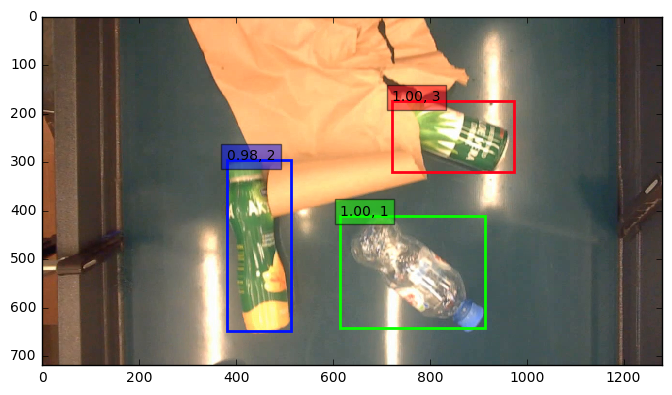

In [14]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()